In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import os
import numpy as np
import time
import re
import h5py
import scipy.io as spio
import scipy as sp

import sys
import seaborn
seaborn.set(font_scale=2)
seaborn.set_style('whitegrid')
clrs = seaborn.color_palette()
from multiprocessing.dummy import Pool
import scipy.spatial.distance as dst
from scipy.stats import multivariate_normal
import scipy.optimize as op
import scipy as sp
sys.path.append('/home/yves/Documents/')
import twoptb as MP

kernel = lambda x1,x2: k*np.exp((-.5)*((x1-x2)**2)/l**2)

##  Helper Functions from Previous Stuff

In [2]:
def calc_post_unNorm(xbar, ybar, C_big, d,  K_bigInv,t,n_neurons):
        
    nT = len(t)
    A = np.squeeze(C_big.dot(xbar)) + np.tile(d,nT)
    
    L1 = np.dot(np.ones(n_neurons*nT),np.exp(A))
    L2 =  ybar.dot(A)
    L3 =  xbar.T.dot(K_bigInv.dot(xbar))
    p = L1 - L2 + L3 
    return p

def calc_post_grad(xbar, ybar, C_big, d,  K_bigInv,t,n_neurons):

    nT = len(t)
    A = np.squeeze(C_big.dot(xbar)) + np.tile(d,nT)

    dL1 = np.dot(np.exp(A),C_big)
    dL2 = np.dot(ybar, C_big)
    dL3 = np.dot(xbar.T,  K_bigInv)

    dL = dL1 - dL2 + dL3

    return np.squeeze(dL)


def calc_post_hess(xbar, ybar, C_big, d, K_bigInv,t,n_neurons):
    
    nT = len(t)

    A = np.squeeze(C_big.dot(xbar)) + np.tile(d,nT)

    Aexpdiagonal = sp.sparse.spdiags(np.exp(A),0,n_neurons*nT,n_neurons*nT)
    temp = Aexpdiagonal.dot(C_big)

    ddL = np.dot(C_big.T, temp) +  K_bigInv
    return ddL

In [3]:
#### UTILITY FUNCTIONS FOR CONVERTING BETWEEN VECTOR AND MATRIX FORMS OF C AND d.
def make_vec_Cd(C,d):
    vecCd = np.vstack([C.T,d]).flatten()
    return vecCd


def makeCd_from_vec(vecCd,nDims,n_neurons):
    C = vecCd[:nDims*n_neurons].reshape(nDims,n_neurons).T
    d = vecCd[nDims*n_neurons:]
    return C,d

def Cd_obs_cost(vecCd,n_neurons,nDims,nT,y,x,postCov):
    """ Calculate the log-likelihood of parameters given 
        current estimate of the latent factors"""
    
    
    C,d = makeCd_from_vec(vecCd,nDims,n_neurons)
    C = C
    LL = 0
    for i in range(nT):
        t1 = C.dot(x[:,i]) + d
        t2 = .5*np.diag(C.dot(postCov[i]).dot(C.T))
        LL += y[:,i].dot(t1) - np.dot(np.ones(n_neurons),np.exp(t1+ t2))
    return -LL

def Cd_grad(vecCd,n_neurons,nDims,nT,y,x,postCov):
    
    C,d = makeCd_from_vec(vecCd,nDims,n_neurons)
    C_grad = np.zeros(C.shape)
    d_grad = np.zeros(d.shape)
    for i in range(nT):

        yhat = np.exp(C.dot(x[:,i]) + d + .5*np.diag(C.dot(postCov[i]).dot(C.T)))
        term2 = np.dot(np.diag(yhat),C.dot(postCov[i]))
        C_grad += np.dot(np.array([y[:,i]-yhat]).T,np.array([x[:,i]])) - term2
        d_grad += y[:,i] - yhat
    return -np.concatenate([C_grad.T.flatten(),d_grad])
    #int ar_grad

In [7]:
def get_sqdists(x,y=None):
    
    if type(y)!=np.ndarray:
        if x.ndim==1:
            dists = dst.pdist(np.vstack([x,np.zeros(x.shape)]).T,metric='sqeuclidean')
        else:
            dists = dst.pdist(x)
            
        dists = dst.squareform(dists)
        
    else:
        if x.ndim==1:
            dists = dst.cdist(np.vstack([x,np.zeros(x.shape)]).T,np.vstack([y,np.zeros(y.shape)]).T,metric='sqeuclidean')
        else:
            dists = dst.cdist(x,y)
    return dists

In [8]:
def calc_K(x,y=None,l=.5,add_offset=1e-3,reshape_params=None):
    
        
    distsSq = get_sqdists(x,y)
    
    cov = (1-add_offset)*np.exp(-.5*distsSq/(l**2)) 
    
    cov += np.eye(len(x))*add_offset
    return cov

In [9]:
def make_Cbig(C,t):
    return np.kron(np.eye(len(t)),C)

In [10]:
def make_Kbig(params,t,nDims,epsNoise=1e-3):

    epsSignal = (1-epsNoise)
    nT = len(t)  #number of time points
    #nDims = params['C'].shape[1] #dimensionality of the latent space
    #nT is
    K_big = np.zeros([nT*nDims,nT*nDims])  
    R_big = np.zeros([nT*nDims,nT*nDims]) 

    for dim in range(nDims):

        for t1_idx,t1 in enumerate(t):

            for t2_idx,t2 in enumerate(t):

                K_big[dim+t1_idx*nDims,dim+t2_idx*nDims] = epsSignal*np.exp((-0.5)*((t1-t2)**2/(params['l'][dim])**2))
                R_big[dim+t1_idx*nDims,dim+t2_idx*nDims] = 1
    return K_big, R_big


#  Ok now lets generate Poisson Data

In [92]:
n_neurons = 40 #q
nDims = 3
n_timePoints = 67
t = np.linspace(-33,33,num=n_timePoints)/10 #use this for an unmarked time series
nT = len(t)

sigmaN = 1e-3
sigmaF = [1-sigmaN for i in range(nDims)]



C = np.random.normal(loc=0,scale=.5,size=(n_neurons,nDims))/2
d = np.random.randint(0,6,size=(n_neurons))/2



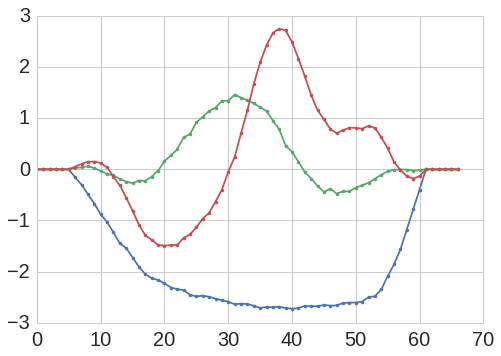

In [100]:
x = np.zeros([nDims,nT])

length_scales_GP = [10**(.3 if i== 0 else -i*.1) for i in range(nDims)]
params = {
          'l':length_scales_GP
         }
#params = [[4,1,2e0],
#          [1,2,1.5e-1],
#          [6,3,1e0]]

for i,l in enumerate(length_scales_GP):
    
    Ki = calc_K(x=t,y=t,l=l)
    Ki /= np.max(Ki)
    mvn1 = multivariate_normal(mean=[np.random.randint(1,7)-3]*n_timePoints,cov=Ki)
    x[i] =  mvn1.rvs()*np.concatenate([np.zeros(5),np.cos(np.linspace(-np.pi/2,0,num=15)),np.ones(nT-35),np.cos(np.linspace(0,.5*np.pi,num=10)),np.zeros(5)])

for i in range(nDims):
    plt.plot(x[i],'.-')
    
#this is the observed data, which we pretend are the spike trains
rate_params = np.exp(C.dot(x) + d[:,None])
y = np.random.poisson(rate_params + np.abs(np.random.normal(loc=0,scale=1,size=rate_params.shape)))

In [94]:
true_params = {'C': C,
          'd': d,
          'l': length_scales_GP}

# Run EM

In [61]:
st = time.time()
ybar = np.array([y.T.flatten()])

xSt = []
CdSt = []
Cst = []
dSt = []
#C_init = np.random.normal(size = C.shape)
#d_init = np.random.normal(size =d.shape)
#xInit = np.random.normal(size = x.shape)

nT = len(t)
nDims = true_params['C'].shape[1]


C_init = np.random.normal(size = (n_neurons,nDims))
d_init = np.random.normal(size =n_neurons)
xInit = np.random.normal(size = (nDims,nT))

nDims = C_init.shape[1]


covSt = []
xSt.append(xInit); Cst.append(C_init); dSt.append(d_init)
K_big,_ = make_Kbig(params,t,nDims,epsNoise=1e-3)
K_bigInv = np.linalg.inv(K_big+ np.eye(K_big.shape[0])*1e-3)
C_big = make_Cbig(Cst[-1],t)
xbar = np.array([xSt[-1].T.flatten()]).T

maxEMiter = 500

for i in range(maxEMiter):
    print i,
    ########################################################################
    ##############               E-Step                     ################
    ########################################################################
    
    K_big,_ = make_Kbig(params,t,nDims,epsNoise=1e-3)
    C_big = make_Cbig(Cst[-1],t)

    resLap = op.minimize(
        fun = calc_post_unNorm,
        x0 = xSt[-1],
        method='Newton-CG',
        args = (ybar, C_big, d, K_bigInv,t,n_neurons),
        jac = calc_post_grad,
        hess = calc_post_hess,
        options = {'disp': False,'maxiter': 10000,'xtol':1e-16
        })


    x_post_mean = resLap.x.reshape(nDims,nT,order='F')
    xSt.append(x_post_mean)
    xbar = np.array([xSt[-1].T.flatten()]).T


    hess = calc_post_hess(resLap.x,  ybar, C_big, d, K_bigInv,t,n_neurons)
    PostCovGP = np.linalg.inv(hess)
    covSt.append(PostCovGP)
    #PostCovGP = PostCovGP
    PostCovOther  = np.zeros(PostCovGP.shape)

    for dim1 in range(nDims):
        for dim2 in range(nDims):
            PostCovOther[dim1*nT:(dim1+1)*nT,dim2*nT:(dim2+1)*nT] = PostCovGP[dim1::nDims,dim2::nDims]

    #here calculate the covariance matrix
    cov_store = np.zeros([nT,nDims,nDims])
    for kk in range(nT):
        cov_store[kk][:,:] = PostCovOther[kk::nT,kk::nT]

    covSt.append(PostCovOther)
    ########################################################################
    ##############               M-Step                     ################
    ########################################################################

    #vecCd = CdtoVecCd(Cst[-1], dSt[-1])
    #xinit = np.random.normal(size=(xdim*ydim+ydim))#np.zeros(xdim*ydim+ydim)
    #xinit = vecCd + np.random.normal(size=(xdim*ydim+ydim))
    T = nT
    vecCd = make_vec_Cd(Cst[-1], dSt[-1])
#Cd_obs_cost(vecCd,n_neurons,nDims,nT,y,x,temp_vsm)

    resCd = op.minimize(
                    fun = Cd_obs_cost,
                    x0 = vecCd,
                    args = (n_neurons,nDims,nT,y,xSt[-1],cov_store),
                    jac = Cd_grad,
                    method = 'TNC',
                    options = {'disp': False, 'maxiter':4000,'ftol':1e-16,'gtol':1e-16,'xtol':1e-16}
                    )

    
    C_inf,d_inf = makeCd_from_vec(resCd.x,nDims,n_neurons)
    #C_inf,D_inf = vecCdtoCd(resCd.x, nDims, n_neurons)
    Cst.append(C_inf); dSt.append(d_inf)
print time.time() - st

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

# Plotting

In [62]:
U,D,V = sp.linalg.svd(Cst[-1])
xSVD = (np.dot(np.diag(D),V.T).dot(xSt[-1]))

In [63]:
U,D,V = sp.linalg.svd(C)
xSVD_true = (np.dot(np.diag(D),V.T).dot(x))

###  Look at Posterior Likelihood

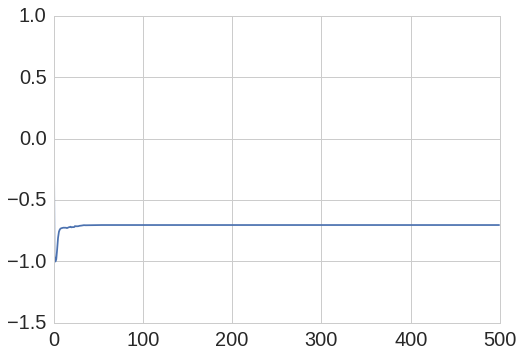

In [64]:
ds = []
for i in range(maxEMiter):
    ds.append(dSt[i][0])
plt.plot(np.log(np.array(ds)))

In [72]:
ls = []
for i in range(maxEMiter):
    xbar_i = np.array([xSt[i].T.flatten()]).T
    d_i = dSt[i]
    C_i = Cst[i]
    Cbig_i = make_Cbig(C_i,t)
    l = calc_post_unNorm(xbar_i, ybar, Cbig_i, d_i,  K_bigInv,t,n_neurons)
    ls.append(int(np.squeeze(l)))

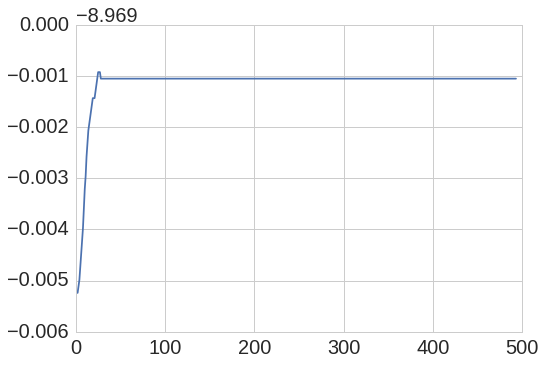

In [80]:
plt.plot(-np.log(-np.array(ls[6:])))

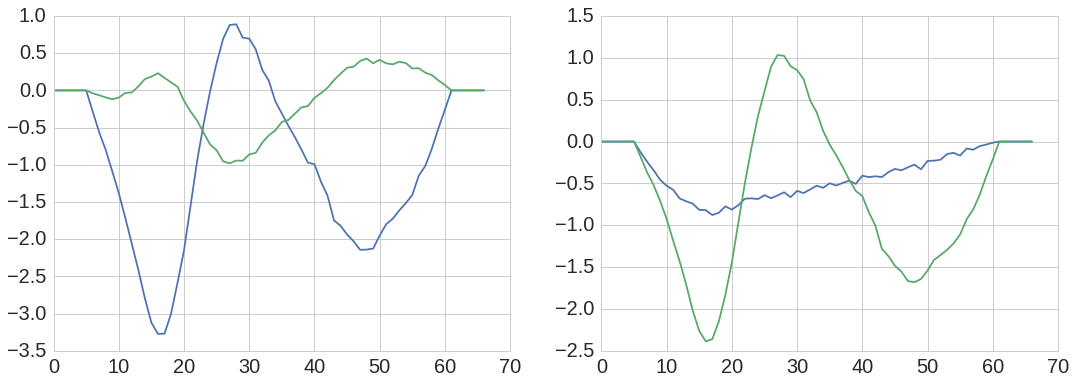

In [81]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
for i in xSVD_true:
    plt.plot(i)
    
plt.subplot(1,2,2)
for i in x:
    plt.plot(i)
    

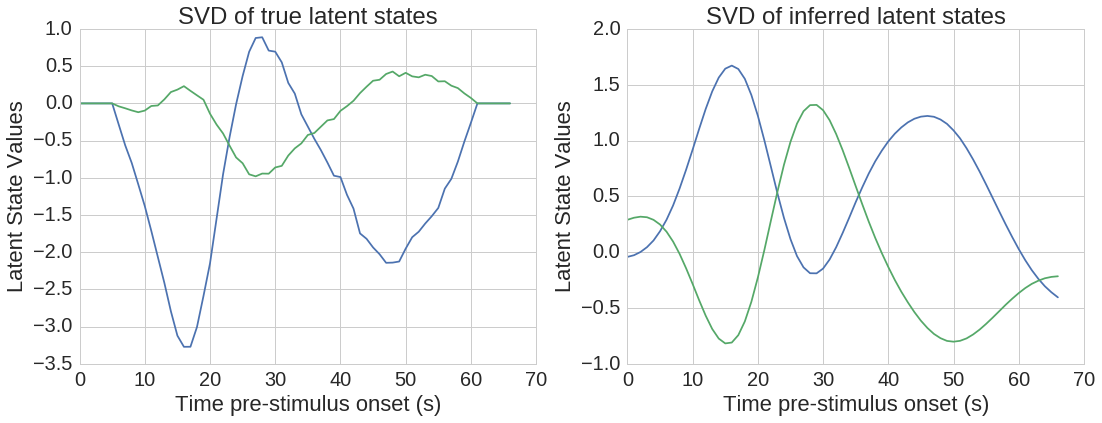

In [82]:
## Plot the SVD of the inferred and ground truth latent state trajectories
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.title('SVD of true latent states')
for i in xSVD_true:
    plt.plot(i)
    plt.xlabel('Time pre-stimulus onset (s)')
    plt.ylabel('Latent State Values')
    
    
plt.subplot(1,2,2)
plt.title('SVD of inferred latent states')
for i in xSVD:
    plt.plot(i)
    plt.xlabel('Time pre-stimulus onset (s)')
    plt.ylabel('Latent State Values')

    

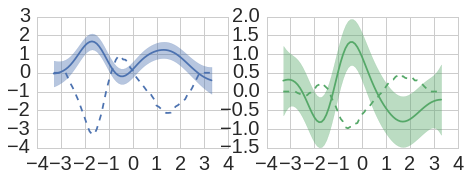

In [83]:
plt.figure(figsize=(24,8))
clrs = seaborn.color_palette('deep',n_colors=nDims,desat=1)#seaborn.color_palette('RdBu',n_colors=3)
SD2 = 2*np.sqrt(PostCovGP.diagonal().reshape(nDims,nT,order='F'))

i = 0
for lapInf,gT in zip(xSVD,xSVD_true):
    plt.subplot(3,6,i+1)    
    plt.plot(t,lapInf,color=clrs[i])
    plt.plot(t,gT,linestyle='--',color=clrs[i])
    plt.fill_between(t,lapInf +SD2[i],lapInf - SD2[i],color=clrs[i],alpha=.4)
    i += 1
    


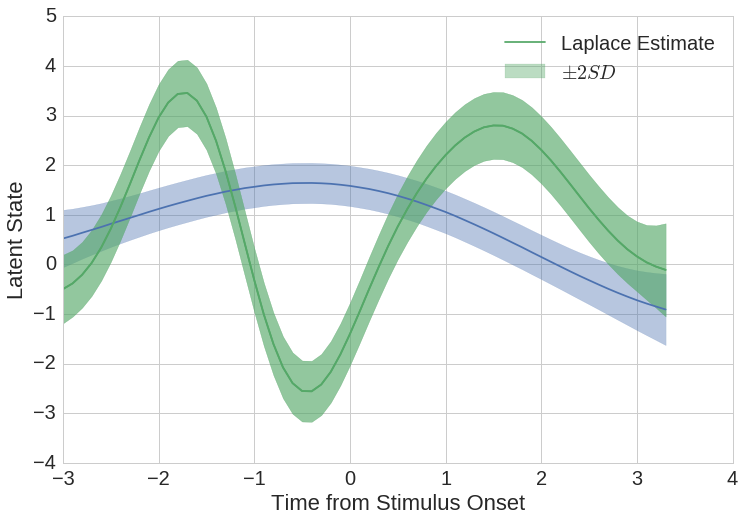

In [85]:
plt.figure(figsize=(12,8))
clrs = seaborn.color_palette('deep',n_colors=nDims+1,desat=1)#seaborn.color_palette('RdBu',n_colors=3)
SD2 = 2*np.sqrt(PostCovGP.diagonal().reshape(nDims,nT,order='F'))
i = 0
for lapInf,gT in zip(xSt[-1],x):
    
    
    plt.plot(t,lapInf,color=clrs[i])
    #plt.plot(t,gT,linestyle='--',color=clrs[i])
    plt.fill_between(t,lapInf +SD2[i],lapInf - SD2[i],color=clrs[i],alpha=.4)
    i += 1
    
plt.plot(t,lapInf,color=clrs[i-1],label='Laplace Estimate')
#plt.plot(t,gT,linestyle='--',color=clrs[i-1],label='Ground Truth')
plt.fill_between(t,lapInf + SD2[i-1],lapInf - SD2[i-1],color=clrs[i-1],alpha=.4,label=r'$\pm2SD$')

plt.ylabel('Latent State')
plt.xlabel('Time from Stimulus Onset')
plt.xlim(-3,)
plt.legend(loc='best')

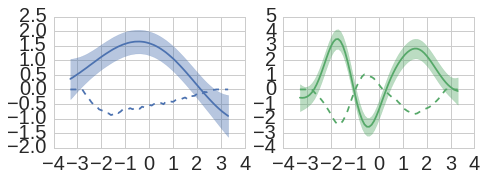

In [86]:
plt.figure(figsize=(24,8))
clrs = seaborn.color_palette('deep',n_colors=nDims,desat=1)#seaborn.color_palette('RdBu',n_colors=3)

i = 0
for lapInf,gT in zip(xSt[-1],x):
    plt.subplot(3,6,i+1)    
    plt.plot(t,lapInf,color=clrs[i])
    plt.plot(t,gT,linestyle='--',color=clrs[i])
    plt.fill_between(t,lapInf +SD2[i],lapInf - SD2[i],color=clrs[i],alpha=.4)
    i += 1
    


In [87]:
np.max(covSt[-1])

0.22004938192559412

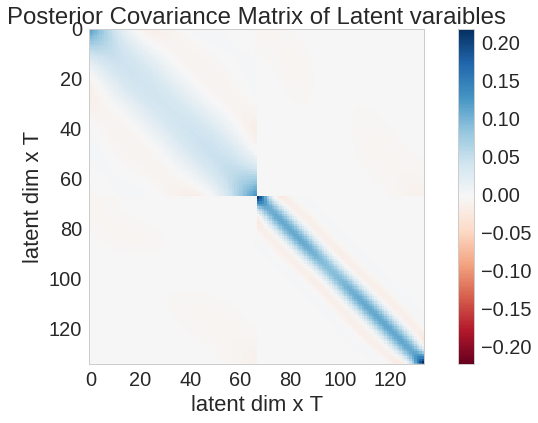

In [88]:
plt.figure(figsize=(12,6))
plt.title('Posterior Covariance Matrix of Latent varaibles')
plt.imshow(covSt[-1],vmax=np.max(covSt[-1]),vmin=-np.max(covSt[-1]),
                     cmap='RdBu',interpolation='None')
plt.xlabel('latent dim x T')
plt.ylabel('latent dim x T')

plt.grid()
plt.colorbar()

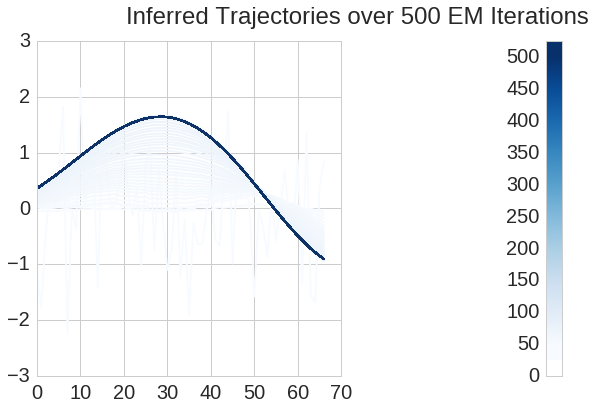

In [89]:
clrs = seaborn.color_palette('Blues',n_colors=int(2+len(xSt)/1),desat=.9)
plt.figure(figsize=(12,6))
plt.suptitle('Inferred Trajectories over %s EM Iterations \n' %maxEMiter)

plt.subplot(1,2,1)
for  i,xs in enumerate(xSt[0::1]):
    plt.plot(xs[0],color=clrs[i],alpha=1)
    
plt.subplot(1,2,2)
plt.imshow(np.flipud(np.array([range(10)]).T),aspect=2,cmap='Blues')
plt.xticks([])
plt.yticks(np.linspace(0,10,num=11),np.linspace(maxEMiter,0,num=11).astype('int'))
plt.grid()

## Plot Firing Rates

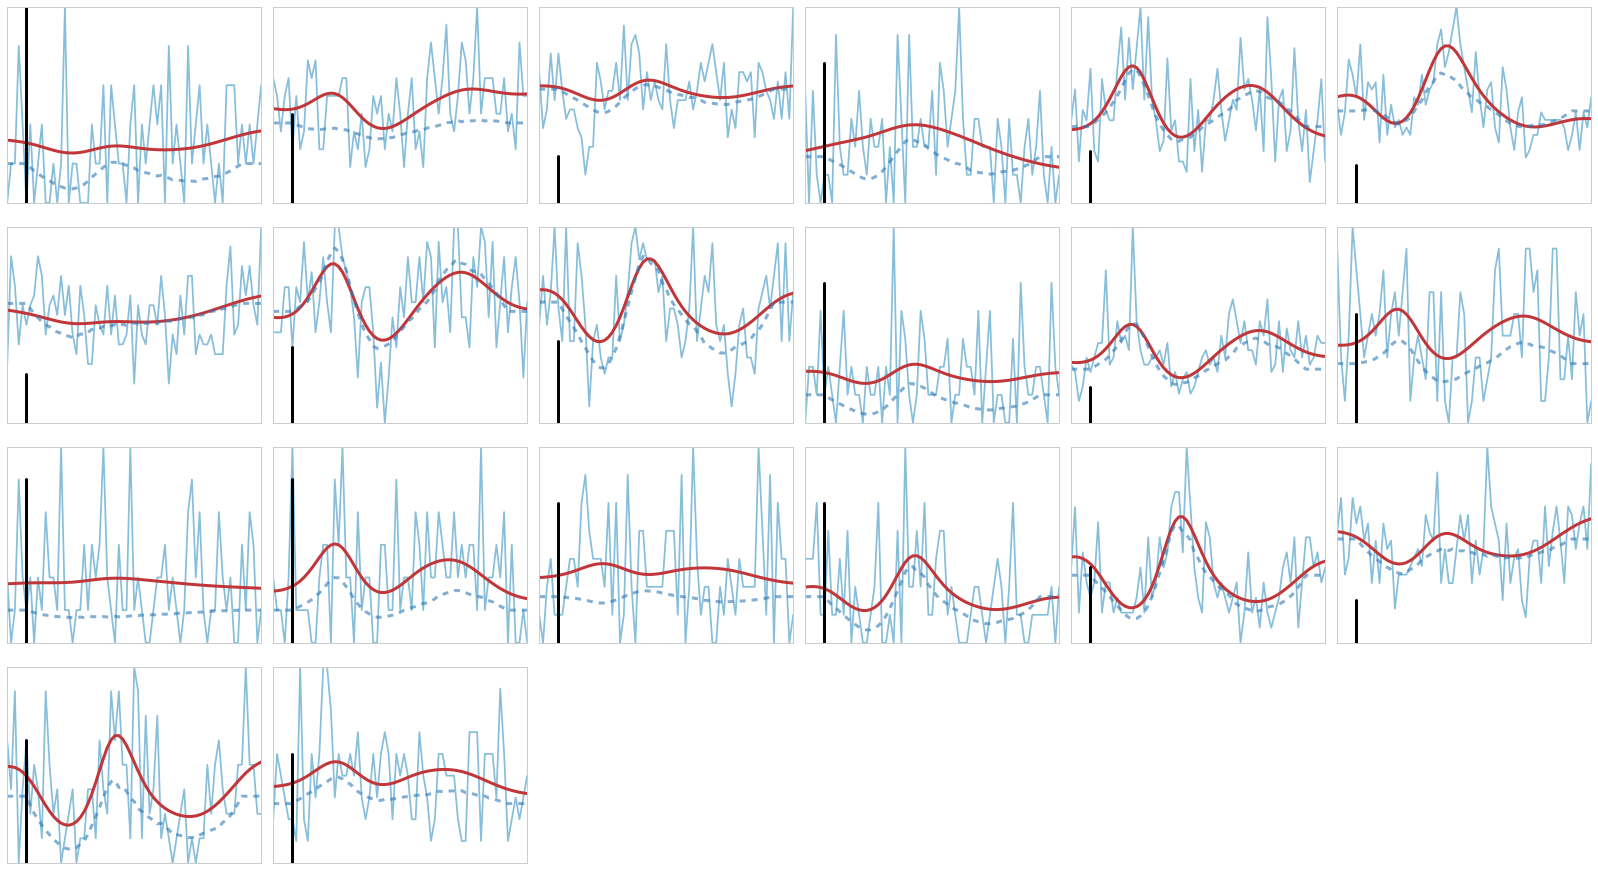

In [90]:
plt.figure(figsize=(22,18))
clrs = seaborn.color_palette('RdBu',n_colors=6)
#plt.suptitle('Inferred, Underlying and Emprirical Firing Rates of Neurons')
nRows, nCols= np.ceil(np.sqrt(n_neurons))+1,np.ceil(np.sqrt(n_neurons))+1

tt = 0

idx = -1
for real,sim in zip(np.exp(C.dot(x).T+d).T,
                    np.exp(Cst[idx].dot(xSt[idx]).T+dSt[idx]).T):
    if tt<143:
        plt.subplot(nRows,nCols,tt+1)
        plt.plot(y[tt],color=clrs[-2])

        plt.plot(sim,color=clrs[0],linewidth=3)
        plt.plot(real,'--',color=clrs[-1],linewidth=3,alpha=0.6)

        plt.xticks([],[])
        plt.yticks([],[])
        plt.grid()
        plt.plot([5,5],[0,5],linewidth=3,color='k')
        #plt.legend()
        
    tt+=1
plt.tight_layout(pad=0, w_pad=0.5, h_pad=1.0)
